Fit a single variable logistic regression model with Jeffreys prior
to simulated data. Plot out both the prior and posterior distributions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate

from bbai.glm import LogisticRegressionMAP

## Generate Dataset

In [2]:
def generate_correlation_matrix(p, param):
    res = np.zeros(shape=(p, p))
    for s in range(p):
        for t in range(0, s+1):
            corr = param
            if s == t:
                corr = 1.0
            res[s, t] = corr
            res[t, s] = corr
    return res

def generate_design_matrix(n, K):
    mean = np.zeros(K.shape[0])
    return np.random.multivariate_normal(mean, K, size=n)

def generate_weights(p):
    return np.random.normal(size=p)

def generate_data_set(n, K):
    p = K.shape[0]
    X = generate_design_matrix(n, K)
    w = generate_weights(p)

    u = np.dot(X, w)

    p = 1 / (1 + np.exp(-u))

    y = []
    for i in range(n):
        y.append(np.random.binomial(1, p[i]))
    y = np.array(y)

    return X, y, w

## Compute Jeffreys Prior

In [3]:
def compute_a_matrix(X, u):
    p_vector = 1 / (1 + np.exp(u))
    return np.diag(p_vector * (1 - p_vector))

def compute_fisher_information_matrix(X, u):
    A = compute_a_matrix(X, u)
    return np.dot(X.T, np.dot(A, X))

def compute_log_prior(X, u):
    FIM = compute_fisher_information_matrix(X, u)
    return 0.5 * np.linalg.slogdet(FIM)[1]

## Compute Posterior

In [4]:
def compute_log_posterior(X, y, w):
    u = np.dot(X, w)
    log_prior = compute_log_prior(X, u)
    y = 2 * y - 1
    likelihood = -np.sum(np.log(1 + np.exp(-y * u)))
    return likelihood + log_prior

## Plot Distributions

In [5]:
np.random.seed(0)

n = 20
p = 1

K = generate_correlation_matrix(p, 0.5)
X, y, w_true = generate_data_set(n, K)

In [6]:
wx = np.arange(-20, 20, 0.1)

### Prior

In [7]:
def f_prior(w):
    u = np.dot(X, np.array([w]))
    return np.exp(compute_log_prior(X, u))

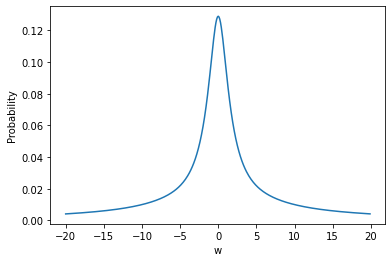

In [8]:
Z,_ = integrate.quad(f_prior, -100, 100)
yx = [f_prior(w)/Z for w in wx]
plt.plot(wx, yx)
plt.xlabel('w')
plt.ylabel('Probability')
plt.show()

### Posterior

In [9]:
model = LogisticRegressionMAP(fit_intercept=False)
model.fit(X, y)
w_map = model.coef_[0]
print('w_true =', w_true[0])
print('w_map = ', w_map[0])

w_true = -2.5529898158340787
w_map =  -3.139874975387916


In [10]:
def f_posterior(w):
    return np.exp(compute_log_posterior(X, y, np.array([w])))

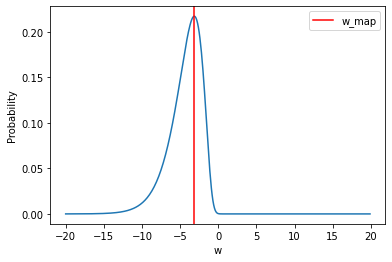

In [11]:
Z,_ = integrate.quad(f_posterior, -100, 100)
yx = [f_posterior(w)/Z for w in wx]
plt.plot(wx, yx)
plt.xlabel('w')
plt.axvline(x=w_map[0], color='red', label='w_map')
plt.ylabel('Probability')
plt.legend()
plt.show()